In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import joblib

In [38]:
# Chargement du dataset

data_raw = pd.read_csv("data/full_landmarks_dataset_features3.csv")

data_raw = data_raw.drop(['total_frames', 'frame_number', 'width', 'height'], axis=1)

data_raw = data_raw[data_raw['label'].isin(['push-up', 'leg extension', 'barbell biceps curl', 'squat'])]

In [39]:
# PCA

data_numbers = data_raw.drop(['video_name', 'label'], axis=1).to_numpy() 
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_numbers)
pca_df = pd.DataFrame(data = pca_result, columns = ['pca1', 'pca2', 'pca3'])
pca_df.head()

# Rajouter les labels, les reps et les video_names dans pca_df
# pca_df['rep'] = data_raw['rep'].values # OPTION 1
pca_df['label'] = data_raw['label'].values
pca_df['video_name'] = data_raw['video_name'].values

# Label encoding
le = LabelEncoder()
pca_df['label'] = le.fit_transform(pca_df['label'])

In [40]:
# Découpage du dataset en séquences de frames

SEQ_LEN = 10   # à ajuster

X_list = []
y_list = []

for (video, group) in pca_df.groupby(['video_name']): # Instruction à bien retenir !!
    
    group = group.sort_index()
    features = group[['pca1', 'pca2', 'pca3']].values
    label = group['label'].iloc[0]
    
    # Echantillonage des séquences
    if len(features) >= SEQ_LEN:
        # On sélectionne SEQ_LEN frames uniformément réparties
        indices = np.linspace(0, len(features) - 1, SEQ_LEN).astype(int)
        features = features[indices]
    else:
        pad = np.zeros((SEQ_LEN - len(features), 3))
        features = np.vstack([features, pad])

    # Flatten pour le MLP
    features = features.flatten()
    
    X_list.append(features)
    y_list.append(label)
    
# Split train/test

groups = []
for (video, group) in pca_df.groupby(['video_name']):
    groups.append(video)
groups = np.array(groups)

In [41]:
# Conversion en tableaux numpy
X = np.array(X_list)
y = np.array(y_list)

# Conversion en tenseurs PyTorch
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

In [42]:
# Split par groupes (vidéos)
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train = X[train_idx]
X_test  = X[test_idx]
y_train = y[train_idx]
y_test  = y[test_idx]

print("Nb vidéos train :", len(np.unique(groups[train_idx])))
print("Nb vidéos test  :", len(np.unique(groups[test_idx])))

Nb vidéos train : 108
Nb vidéos test  : 27


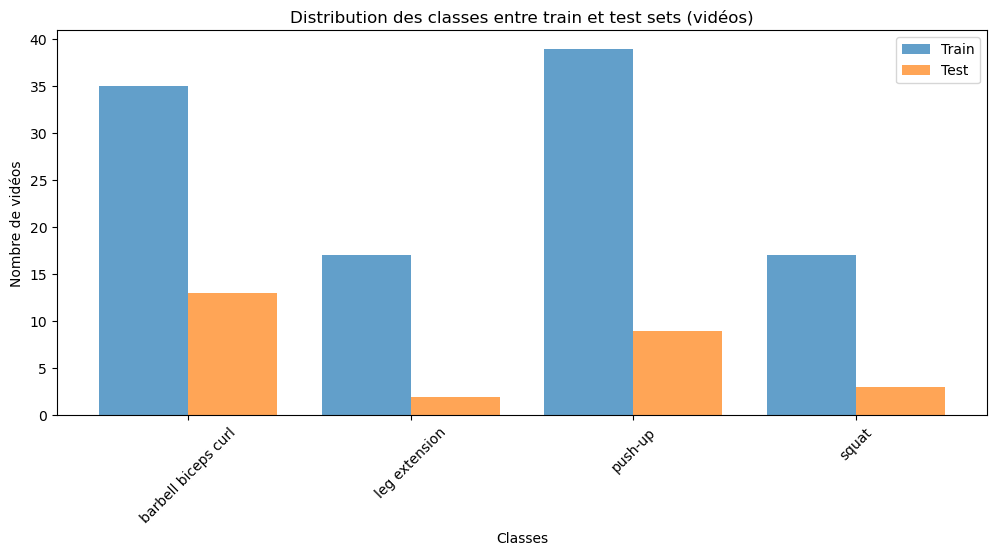

In [43]:
# Répartition des classes dans train et test

train_labels, train_counts = np.unique(y_train.numpy(), return_counts=True)
test_labels, test_counts = np.unique(y_test.numpy(), return_counts=True)

plt.figure(figsize=(12,5))
x = np.arange(len(le.classes_))
plt.bar(x - 0.2, train_counts, width=0.4, alpha=0.7, label='Train')
plt.bar(x + 0.2, test_counts, width=0.4, alpha=0.7, label='Test')
plt.xticks(ticks=x, labels=le.classes_, rotation=45)
plt.xlabel('Classes')
plt.ylabel('Nombre de vidéos')
plt.legend()
plt.title('Distribution des classes entre train et test sets (vidéos)')
plt.show()

In [44]:
# Reshape pour CNN 1D

X_train = X_train.view(X_train.shape[0], SEQ_LEN, 3).permute(0, 2, 1)
X_test  = X_test.view(X_test.shape[0],  SEQ_LEN, 3).permute(0, 2, 1)

In [45]:
# Définition des modèles (finalement on utilise le CNN 1D)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
class CNN1D(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN1D, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        # SEQ_LEN = 10
        # Après 2 pool /2 : 10 → 5 → 2
        self.fc1 = nn.Linear(64 * 2, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))

        x = x.view(x.size(0), -1)

        x = self.relu3(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


In [46]:
# Entrainement et évaluation du modèle

# model = MLP(input_size=30, hidden_size=100, num_classes=4)  # Ancien modèle
model = CNN1D(num_classes=4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Listes pour stocker les métriques
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Entrainement
num_epochs = 50
for epoch in range(num_epochs):
    # Mode entraînement
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    # Calcul de l'accuracy sur train
    _, predicted_train = torch.max(outputs.data, 1)
    train_accuracy = (predicted_train == y_train).sum().item() / y_train.size(0)
    
    # Mode évaluation pour test
    model.eval()
    with torch.no_grad():
        outputs_test = model(X_test)
        test_loss = criterion(outputs_test, y_test)
        _, predicted_test = torch.max(outputs_test.data, 1)
        test_accuracy = (predicted_test == y_test).sum().item() / y_test.size(0)
    
    # Sauvegarde des métriques
    train_losses.append(loss.item())
    test_losses.append(test_loss.item())
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Train Acc: {train_accuracy:.4f}, Test Loss: {test_loss.item():.4f}, Test Acc: {test_accuracy:.4f}')

Epoch [10/50], Train Loss: 0.5068, Train Acc: 0.8519, Test Loss: 0.5868, Test Acc: 0.7778
Epoch [20/50], Train Loss: 0.1955, Train Acc: 0.9537, Test Loss: 0.2022, Test Acc: 0.9259
Epoch [30/50], Train Loss: 0.1519, Train Acc: 0.9630, Test Loss: 0.2043, Test Acc: 0.9259
Epoch [40/50], Train Loss: 0.1363, Train Acc: 0.9630, Test Loss: 0.1875, Test Acc: 0.8889
Epoch [50/50], Train Loss: 0.0731, Train Acc: 0.9815, Test Loss: 0.1543, Test Acc: 0.9259


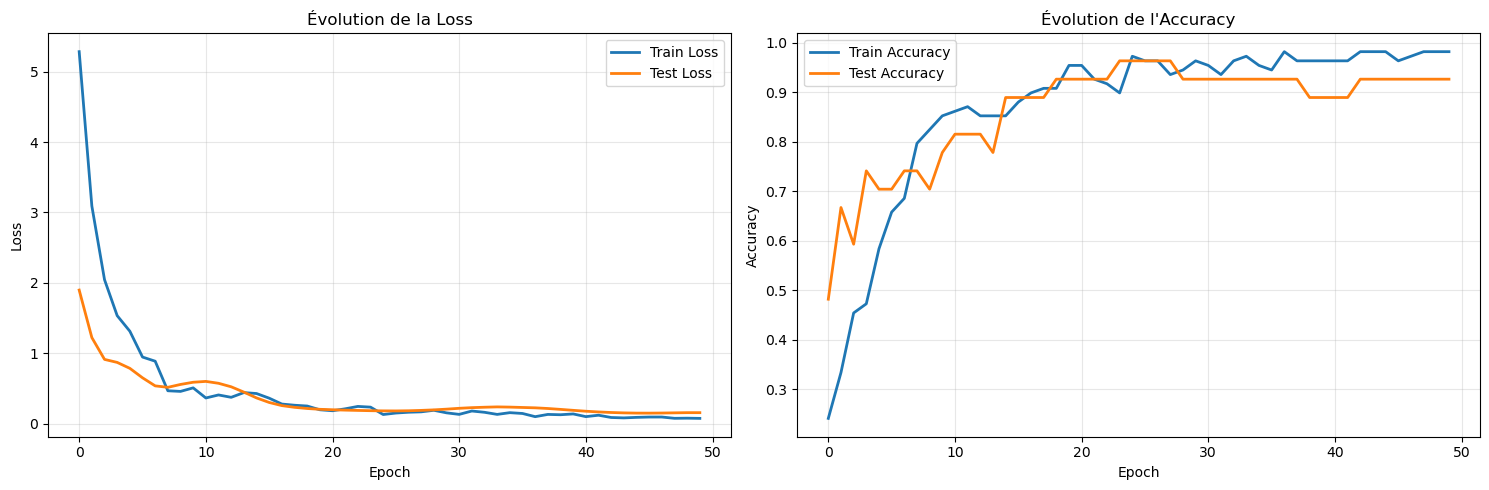


Meilleure accuracy test : 0.9630 (epoch 24)
Accuracy finale test : 0.9259


In [47]:
# Courbes d'apprentissage

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Courbe de loss
ax1.plot(train_losses, label='Train Loss', linewidth=2)
ax1.plot(test_losses, label='Test Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Évolution de la Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Courbe d'accuracy
ax2.plot(train_accuracies, label='Train Accuracy', linewidth=2)
ax2.plot(test_accuracies, label='Test Accuracy', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Évolution de l\'Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nMeilleure accuracy test : {max(test_accuracies):.4f} (epoch {test_accuracies.index(max(test_accuracies))+1})")
print(f"Accuracy finale test : {test_accuracies[-1]:.4f}")

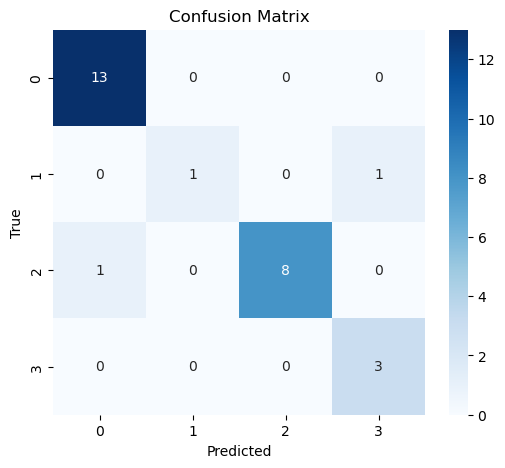

              precision    recall  f1-score   support

           0     0.9286    1.0000    0.9630        13
           1     1.0000    0.5000    0.6667         2
           2     1.0000    0.8889    0.9412         9
           3     0.7500    1.0000    0.8571         3

    accuracy                         0.9259        27
   macro avg     0.9196    0.8472    0.8570        27
weighted avg     0.9378    0.9259    0.9220        27



In [48]:
# Prédictions
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    _, y_pred = torch.max(outputs, 1)

# Matrice de confusion
cm = confusion_matrix(y_test.cpu().numpy(), y_pred.cpu().numpy())

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Rapport détaillé
print(classification_report(
    y_test.cpu().numpy(),
    y_pred.cpu().numpy(),
    digits=4
))


In [55]:
# Analyse des résultats par vidéo

test_video_names = np.ravel(np.array(groups[test_idx]))

y_test_np = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else np.array(y_test)
y_pred_np = y_pred.cpu().numpy() if isinstance(y_pred, torch.Tensor) else np.array(y_pred)

y_test_np = np.ravel(y_test_np)
y_pred_np = np.ravel(y_pred_np)

summary_df = pd.DataFrame({
    "video": test_video_names,
    "true_id": y_test_np,
    "pred_id": y_pred_np
})
summary_df["correct"] = summary_df["true_id"] == summary_df["pred_id"]
summary_df["true_label"] = le.inverse_transform(summary_df["true_id"].astype(int))
summary_df["pred_label"] = le.inverse_transform(summary_df["pred_id"].astype(int))

mis_df = summary_df[~summary_df["correct"]]
cor_df = summary_df[summary_df["correct"]]

print(f"Total vidéos test: {len(summary_df)}")
print(f"Vidéos bien classifiées : {cor_df['video'].nunique()}")
print(f"Vidéos mal classifiées : {mis_df['video'].nunique()}")

if not mis_df.empty:
    print("\nVidéos mal classifiées (avec vrai/pred):")
    display(mis_df[["video", "true_label", "pred_label"]].drop_duplicates())
else:
    print("\nAucune vidéo mal classifiée.")

print("\nVidéos bien classifiées:")
if not cor_df.empty:
    display(cor_df[["video", "true_label", "pred_label"]].drop_duplicates())
else:
    print("(aucune)")

print("\nRépartition des labels dans le test:")
print(summary_df["true_label"].value_counts())

Total vidéos test: 27
Vidéos bien classifiées : 25
Vidéos mal classifiées : 2

Vidéos mal classifiées (avec vrai/pred):


,video,true_label,pred_label
14,leg extension_24.mp4,leg extension,squat
16,push-up_26.mp4,push-up,barbell biceps curl



Vidéos bien classifiées:


,video,true_label,pred_label
0,barbell biceps curl_15.mp4,barbell biceps curl,barbell biceps curl
1,barbell biceps curl_22.mp4,barbell biceps curl,barbell biceps curl
2,barbell biceps curl_24.mp4,barbell biceps curl,barbell biceps curl
3,barbell biceps curl_28.mp4,barbell biceps curl,barbell biceps curl
4,barbell biceps curl_3.mp4,barbell biceps curl,barbell biceps curl
5,barbell biceps curl_30.mp4,barbell biceps curl,barbell biceps curl
6,barbell biceps curl_39.mp4,barbell biceps curl,barbell biceps curl
7,barbell biceps curl_4.mp4,barbell biceps curl,barbell biceps curl
8,barbell biceps curl_43.mp4,barbell biceps curl,barbell biceps curl
9,barbell biceps curl_58.mp4,barbell biceps curl,barbell biceps curl



Répartition des labels dans le test:
true_label
barbell biceps curl    13
push-up                 9
squat                   3
leg extension           2
Name: count, dtype: int64


In [56]:
# Pour finir, sauvegarde du modèle et de la PCA

torch.save(model.state_dict(), "models/cnn_model.pth")
joblib.dump(pca, "models/pca.pkl")


['models/pca.pkl']